In [1]:
%matplotlib inline

In [2]:
import os
import sys
import wget
from collections import OrderedDict

import torch
import torchvision
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../../../')
import utils
from video_processing.mask_rcnn.dataset.penn_fudan_ped import PennFudanDataset, get_transform
from video_processing.mask_rcnn.utils.utils import read_annotation, display_image_overlay

image  <class 'torch.Tensor'> torch.Size([3, 438, 567]) torch.uint8
mask  <class 'torch.Tensor'> torch.Size([1, 438, 567]) torch.uint8
{'obj_num': [1, 2, 3, 4], 'label': ['PASpersonWalking', 'PASpersonWalking', 'PASpersonStanding', 'PASpersonWalking'], 'bbox': [[[178, 123], [271, 410]], [[299, 114], [370, 335]], [[446, 104], [507, 315]], [[521, 119], [565, 258]]]}


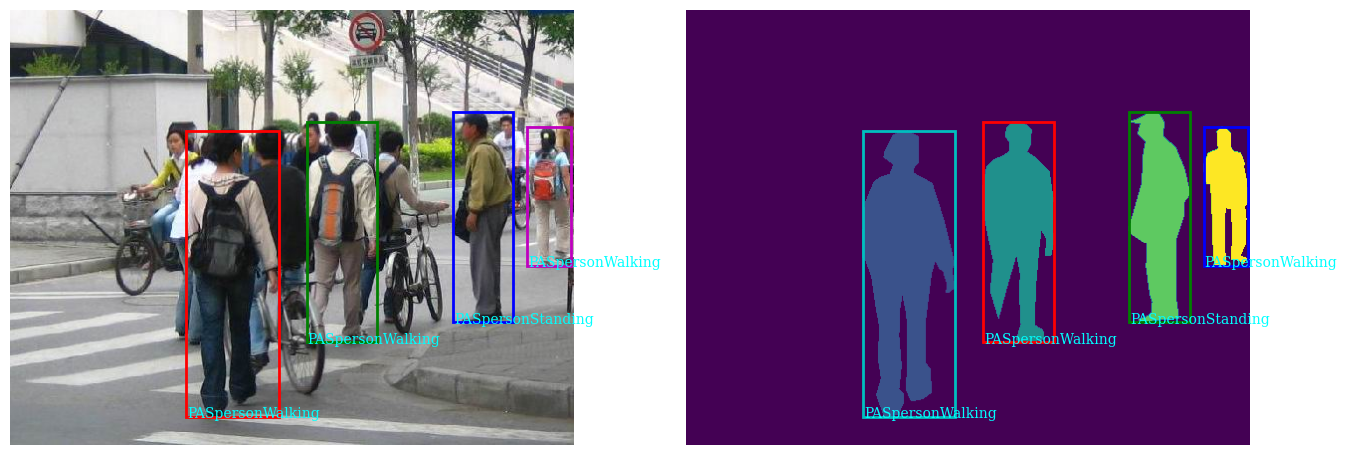

In [3]:
main_dirpath='D:/data'
tensor_dirpath=os.path.join(main_dirpath, 'mask_rcnn')

image=read_image(os.path.join(main_dirpath, 'PennFudanPed/PNGImages/FudanPed00046.png')) # CxHxW -> CxYxX
mask=read_image(os.path.join(main_dirpath, 'PennFudanPed/PedMasks/FudanPed00046_mask.png')) # CxHxW -> CxYxX
print('image ', type(image), image.shape, image.dtype)
print('mask ', type(mask), mask.shape, mask.dtype)

annotation=read_annotation(os.path.join(main_dirpath, 'PennFudanPed/Annotation/FudanPed00046.txt'))
print(annotation)
display_image_overlay(image=image, mask=mask, annotation=annotation)

In [4]:
main_url='https://raw.githubusercontent.com/pytorch/vision/main/references/detection'
for file in ['engine.py', 'utils.py','coco_utils.py','coco_eval.py', 'transforms.py']:
    if os.path.isfile(file): continue
    out=wget.download(url=f'{main_url}/{file}', out=None)
    print(file, out)

In [5]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device ', device)

num_classes=2
# load an instance segmentation model pre-trained on COCO
model=torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT', rpn_pre_nms_top_n_train=800,
        rpn_pre_nms_top_n_test=500,  rpn_post_nms_top_n_train=800,  rpn_post_nms_top_n_test=500, box_detections_per_img=100,
        box_batch_size_per_image =400, rpn_batch_size_per_image=100)
# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features
print('the number of inpute features for classifiers ', in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,  num_classes)

# get the number of input features for the mask classifiers
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
print('the number of input features for mask ', in_features_mask)
hidden_layer=256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# move model to the right device
model.to(device);

device  cpu
the number of inpute features for classifiers  1024
the number of input features for mask  256


In [6]:
import torch

import utils
from video_processing.mask_rcnn.dataset.penn_fudan_ped import PennFudanDataset, get_transform

train_dataset=PennFudanDataset(root=os.path.join(main_dirpath, 'PennFudanPed'), image_dirname='PNGImages', mask_dirname='PedMasks',
                               annotation_dirname='Annotation', transforms=get_transform(is_train=True))#, image_mean=model.transform.image_mean, image_std=model.transform.image_std,
                                                  #min_size=model.transform.min_size, max_size=model.transform.max_size))

# define training and validation data loaders
tarin_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2,shuffle=True,collate_fn=utils.collate_fn)

2  images  [torch.Size([3, 354, 466]), torch.Size([3, 349, 336])] [(torch.float32, tensor(0.), tensor(1.)), (torch.float32, tensor(0.), tensor(1.))]
2  targets  [{'boxes': torch.Size([2, 4]), 'masks': torch.Size([2, 354, 466]), 'labels': torch.Size([2]), 'image_id': 143, 'area': torch.Size([2]), 'iscrowd': torch.Size([2])}, {'boxes': torch.Size([1, 4]), 'masks': torch.Size([1, 349, 336]), 'labels': torch.Size([1]), 'image_id': 14, 'area': torch.Size([1]), 'iscrowd': torch.Size([1])}]
masks  [(torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8)), (torch.uint8, tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8))]


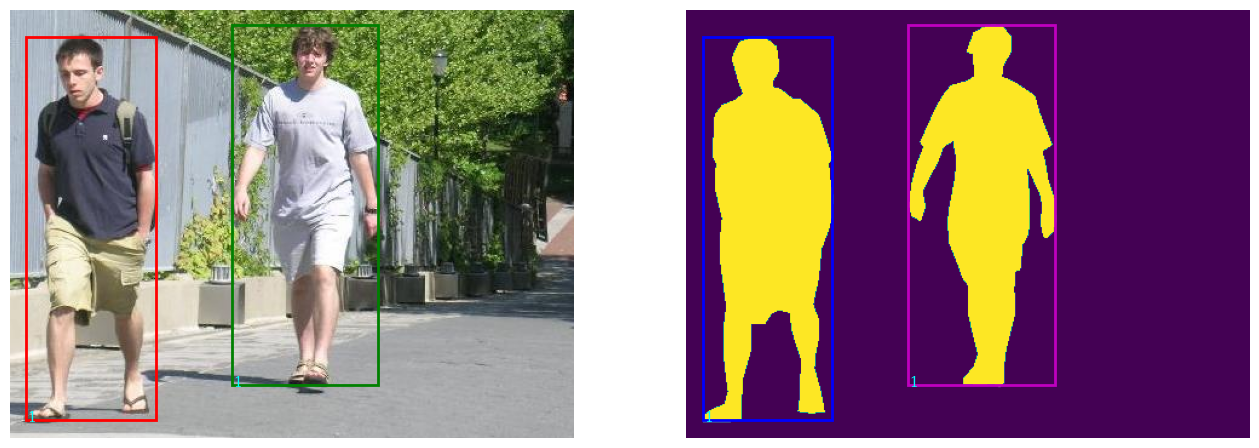

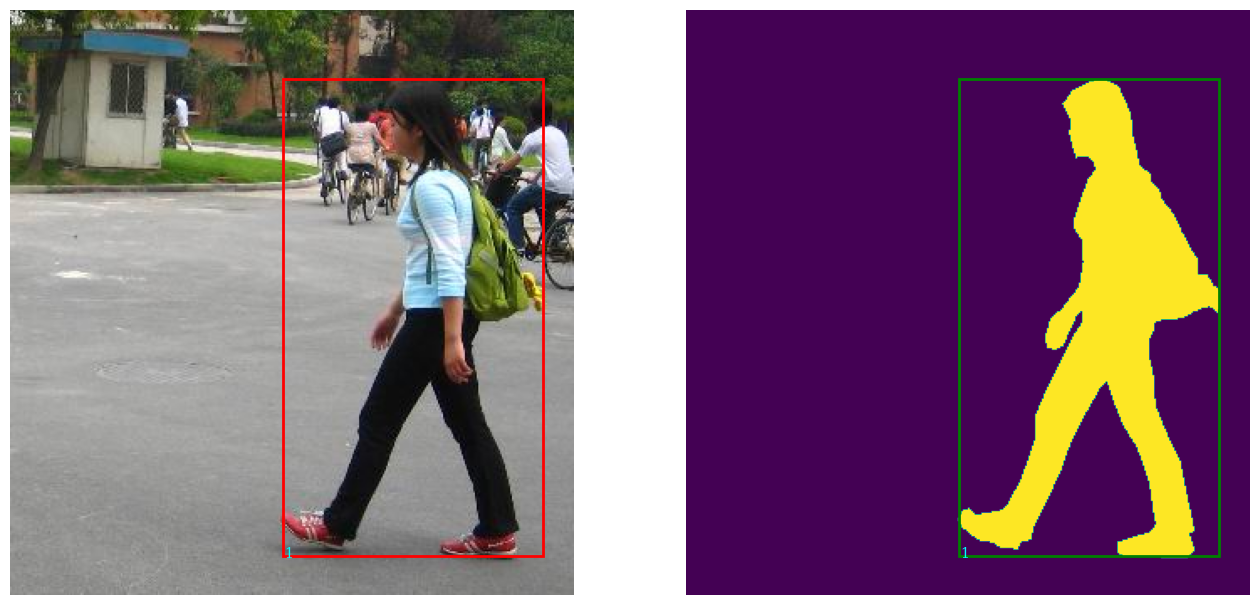

In [7]:
# For training
images, targets=next(iter(tarin_loader))
print(len(images), ' images ', [x.shape for x in images], [(x.dtype, x.min(), x.max()) for x in images])
print(len(targets), ' targets ', [{k:(v if not isinstance(v, torch.Tensor) else v.shape) for k, v in target.items()} for target in targets])
print('masks ', [(target['masks'].dtype, target['masks'].min(), target['masks'].max()) for target in targets])


for i in range(len(images)):
    annotation={'bbox':[[box.squeeze()[2*i:(2*i+2)] for i in range(2)] for box in targets[i]['boxes'].split(1, dim=0)],
              'label':[f'{l}' for l in targets[i]['labels']]}
    display_image_overlay(image=(images[i]*255).type(torch.uint8), mask=targets[i]['masks'].sum(dim=0, keepdim=True), annotation=annotation)

In [8]:
torch.save({'images':images, 'targets':targets}, os.path.join(tensor_dirpath, 'part-backbonefpn-orig_input.pt'))

[`forward`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py)

In [9]:
for target in targets:
    boxes=target['boxes']
    if isinstance(boxes, torch.Tensor):
        assert len(boxes.shape)==2 and boxes.shape[-1]==4, f'Expect target boxes to be a tensor of shape [N, 4], get {boxes.shape}'
    else: raise ValueError(f'Expect target boxes to be Tensor of shape [N, 4], got {type(boxes)}')
    print('boxes ', boxes.shape)

boxes  torch.Size([2, 4])
boxes  torch.Size([1, 4])


In [10]:
original_image_sizes: list[tuple[int, int]] = []
for img in images:
    val=image.shape[-2:]
    assert image.dim()==3, f'Expect two dimension image with channel dimension but got {img.shape} instead'
    original_image_sizes.append((val[0], val[1]))
    print(val)

torch.Size([438, 567])
torch.Size([438, 567])


In [11]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [12]:
tfm_images, tfm_targets = model.transform(images, targets)
print('tfm_images ', tfm_images.image_sizes, [im.shape for im in tfm_images.tensors], )

tfm_images  [(800, 1053), (830, 800)] [torch.Size([3, 832, 1056]), torch.Size([3, 832, 1056])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].


0 torch.Size([3, 832, 1056]) torch.float32 -2.108191967010498 2.640000343322754
1 torch.Size([3, 832, 1056]) torch.float32 -2.11067795753479 2.640000343322754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].


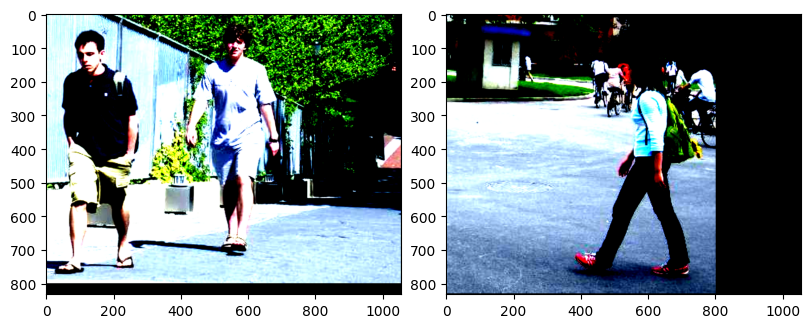

In [13]:
fig, axes=plt.subplots(1,2,figsize=(8,3))
for i, im in enumerate(tfm_images.tensors):
    print(i, im.shape, im.dtype, im.min().item(), im.max().item())
    axes[i].imshow(im.permute(1,2,0).numpy())
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

In [14]:
# Check for degenerate boxes
for target_idx, target in enumerate(tfm_targets):
    boxes=target['boxes'] # Nbx4
    degenerate_boxes=boxes[:,2:]<=boxes[:,:2] # Nbx2
    if degenerate_boxes.any():
        # print the first degenerate box
        bb_idx=torch.nonzero(degenerate_boxes.any(dim=1), as_tuple=True)[0][0]
        degen_bb=boxes[bb_idx].tolist()
        raise ValueError(f'All bounding box should have positive height and width.\n Found invalid box {degen_bb} for target at index {target_idx}')


[`BackboneWithFPN`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py)

[`forward`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py)

#### backbone declaration
Line 502-503
[`maskrcnn_resnet50_fpn`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/mask_rcnn.py)

[`_resnet_fpn_extractor`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py)

[`model.backbone.body.forward`](https://github.com/pytorch/vision/blob/main/torchvision/models/_utils.py) in `IntermediateLayerGetter`

In [15]:
# this from https://github.com/pytorch/vision/blob/main/torchvision/models/_utils.py
print('model.backbone.body.return_layers ', model.backbone.body.return_layers)

x=tfm_images.tensors

out = OrderedDict()
for i, (name, module) in enumerate(model.backbone.body.items()):
    x=module(x)
    print(name, x.shape)
    if name in model.backbone.body.return_layers:
        out_name=model.backbone.body.return_layers[name]
        out[out_name]=x


model.backbone.body.return_layers  {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}
conv1 torch.Size([2, 64, 416, 528])
bn1 torch.Size([2, 64, 416, 528])
relu torch.Size([2, 64, 416, 528])
maxpool torch.Size([2, 64, 208, 264])
layer1 torch.Size([2, 256, 208, 264])
layer2 torch.Size([2, 512, 104, 132])
layer3 torch.Size([2, 1024, 52, 66])
layer4 torch.Size([2, 2048, 26, 33])


[`forward`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py)

[`FeaturePyramidNetwork`](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py)
[`forward`](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py)

In [16]:
print({k:v.shape for k, v in out.items()})

{'0': torch.Size([2, 256, 208, 264]), '1': torch.Size([2, 512, 104, 132]), '2': torch.Size([2, 1024, 52, 66]), '3': torch.Size([2, 2048, 26, 33])}


In [17]:
x=out
names=list(x.keys())
x=list(x.values())

last_inner=model.backbone.fpn.inner_blocks[-1](x[-1]) # line 187 https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py
result=[None]*len(x)
result[-1]=model.backbone.fpn.layer_blocks[-1](last_inner)
print('result ', [(r.shape, r.min().item(), r.max().item()) if isinstance(r, torch.Tensor) else None for r in result])

for idx in range(len(x)-2, -1, -1):
    print(idx, '-'*70)
    inner_lateral=model.backbone.fpn.inner_blocks[idx](x[idx])
    inner_top_down=F.interpolate(last_inner, size=inner_lateral.shape[-2:], mode='nearest')
    last_inner=inner_lateral+inner_top_down
    result[idx]=model.backbone.fpn.layer_blocks[idx](last_inner)
    #result.insert(0, model.backbone.fpn.layer_blocks[idx](last_inner))
    print('\tinner_lateral ', inner_lateral.shape)
    print('\tinner_top_down ', inner_top_down.shape)
    print('\tlast_inner ', last_inner.shape)
    print('\tresult ', len(result), [r.shape if isinstance(r, torch.Tensor) else None for r in result])

result  [None, None, None, (torch.Size([2, 256, 26, 33]), -1.5852569341659546, 1.9735815525054932)]
2 ----------------------------------------------------------------------
	inner_lateral  torch.Size([2, 256, 52, 66])
	inner_top_down  torch.Size([2, 256, 52, 66])
	last_inner  torch.Size([2, 256, 52, 66])
	result  4 [None, None, torch.Size([2, 256, 52, 66]), torch.Size([2, 256, 26, 33])]
1 ----------------------------------------------------------------------
	inner_lateral  torch.Size([2, 256, 104, 132])
	inner_top_down  torch.Size([2, 256, 104, 132])
	last_inner  torch.Size([2, 256, 104, 132])
	result  4 [None, torch.Size([2, 256, 104, 132]), torch.Size([2, 256, 52, 66]), torch.Size([2, 256, 26, 33])]
0 ----------------------------------------------------------------------
	inner_lateral  torch.Size([2, 256, 208, 264])
	inner_top_down  torch.Size([2, 256, 208, 264])
	last_inner  torch.Size([2, 256, 208, 264])
	result  4 [torch.Size([2, 256, 208, 264]), torch.Size([2, 256, 104, 132]), 

[`LastLevelMaxPool`](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py) # line 207

```
results, names = self.extra_blocks(results, x, names)
```

In [18]:
print(model.backbone.fpn.extra_blocks)
#Applies a max_pool2d (not actual max_pool2d, we just subsample) on top of the last feature map
names.append("pool")
# Use max pooling to simulate stride 2 subsampling
result.append(F.max_pool2d(result[-1], kernel_size=1, stride=2, padding=0))

# make it back an OrderedDict
out = OrderedDict([(k, v) for k, v in zip(names, result)])

LastLevelMaxPool()


In [19]:
for k, v in out.items():
    print(k, v.shape, v.min().item(), v.max().item())

0 torch.Size([2, 256, 208, 264]) -2.1181082725524902 2.168463945388794
1 torch.Size([2, 256, 104, 132]) -1.646379828453064 1.6166932582855225
2 torch.Size([2, 256, 52, 66]) -1.5383321046829224 1.5961196422576904
3 torch.Size([2, 256, 26, 33]) -1.5852569341659546 1.9735815525054932
pool torch.Size([2, 256, 13, 17]) -1.4886037111282349 1.6521222591400146


In [21]:
torch.save({'tfm_images':tfm_images, 'tmf_targets':tfm_targets, 'out':out}, os.path.join(tensor_dirpath, 'part-backbonefpn-transform.pt'))